In [1]:
import os
from keys import OPENAI_API_KEY, GOOGLE_API_KEY, GOOGLE_CSE_ID
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY
os.environ["GOOGLE_API_KEY"] = GOOGLE_API_KEY
os.environ["GOOGLE_CSE_ID"] = GOOGLE_CSE_ID

## Augment Blog Posts with Google Search

In [2]:
title = "OpenAI CEO: AI regulation 'is essential'"

text_all = """ Altman highlighted the potential benefits of AI technologies like ChatGPT and Dall-E 2 to help address significant challenges such as climate change and cancer, but he also stressed the need to mitigate the risks associated with increasingly powerful AI models. Altman proposed that governments consider implementing licensing and testing requirements for AI models that surpass a certain threshold of capabilities. He highlighted OpenAI’s commitment to safety and extensive testing before releasing any new systems, emphasising the company’s belief that ensuring the safety of AI is crucial. Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology. Blumenthal raised concerns about various risks associated with AI, including deepfakes, weaponised disinformation, discrimination, harassment, and impersonation fraud. He also emphasised the potential displacement of workers in the face of a new industrial revolution driven by AI."""

text_to_change = """ Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology."""

### Flow Diagram

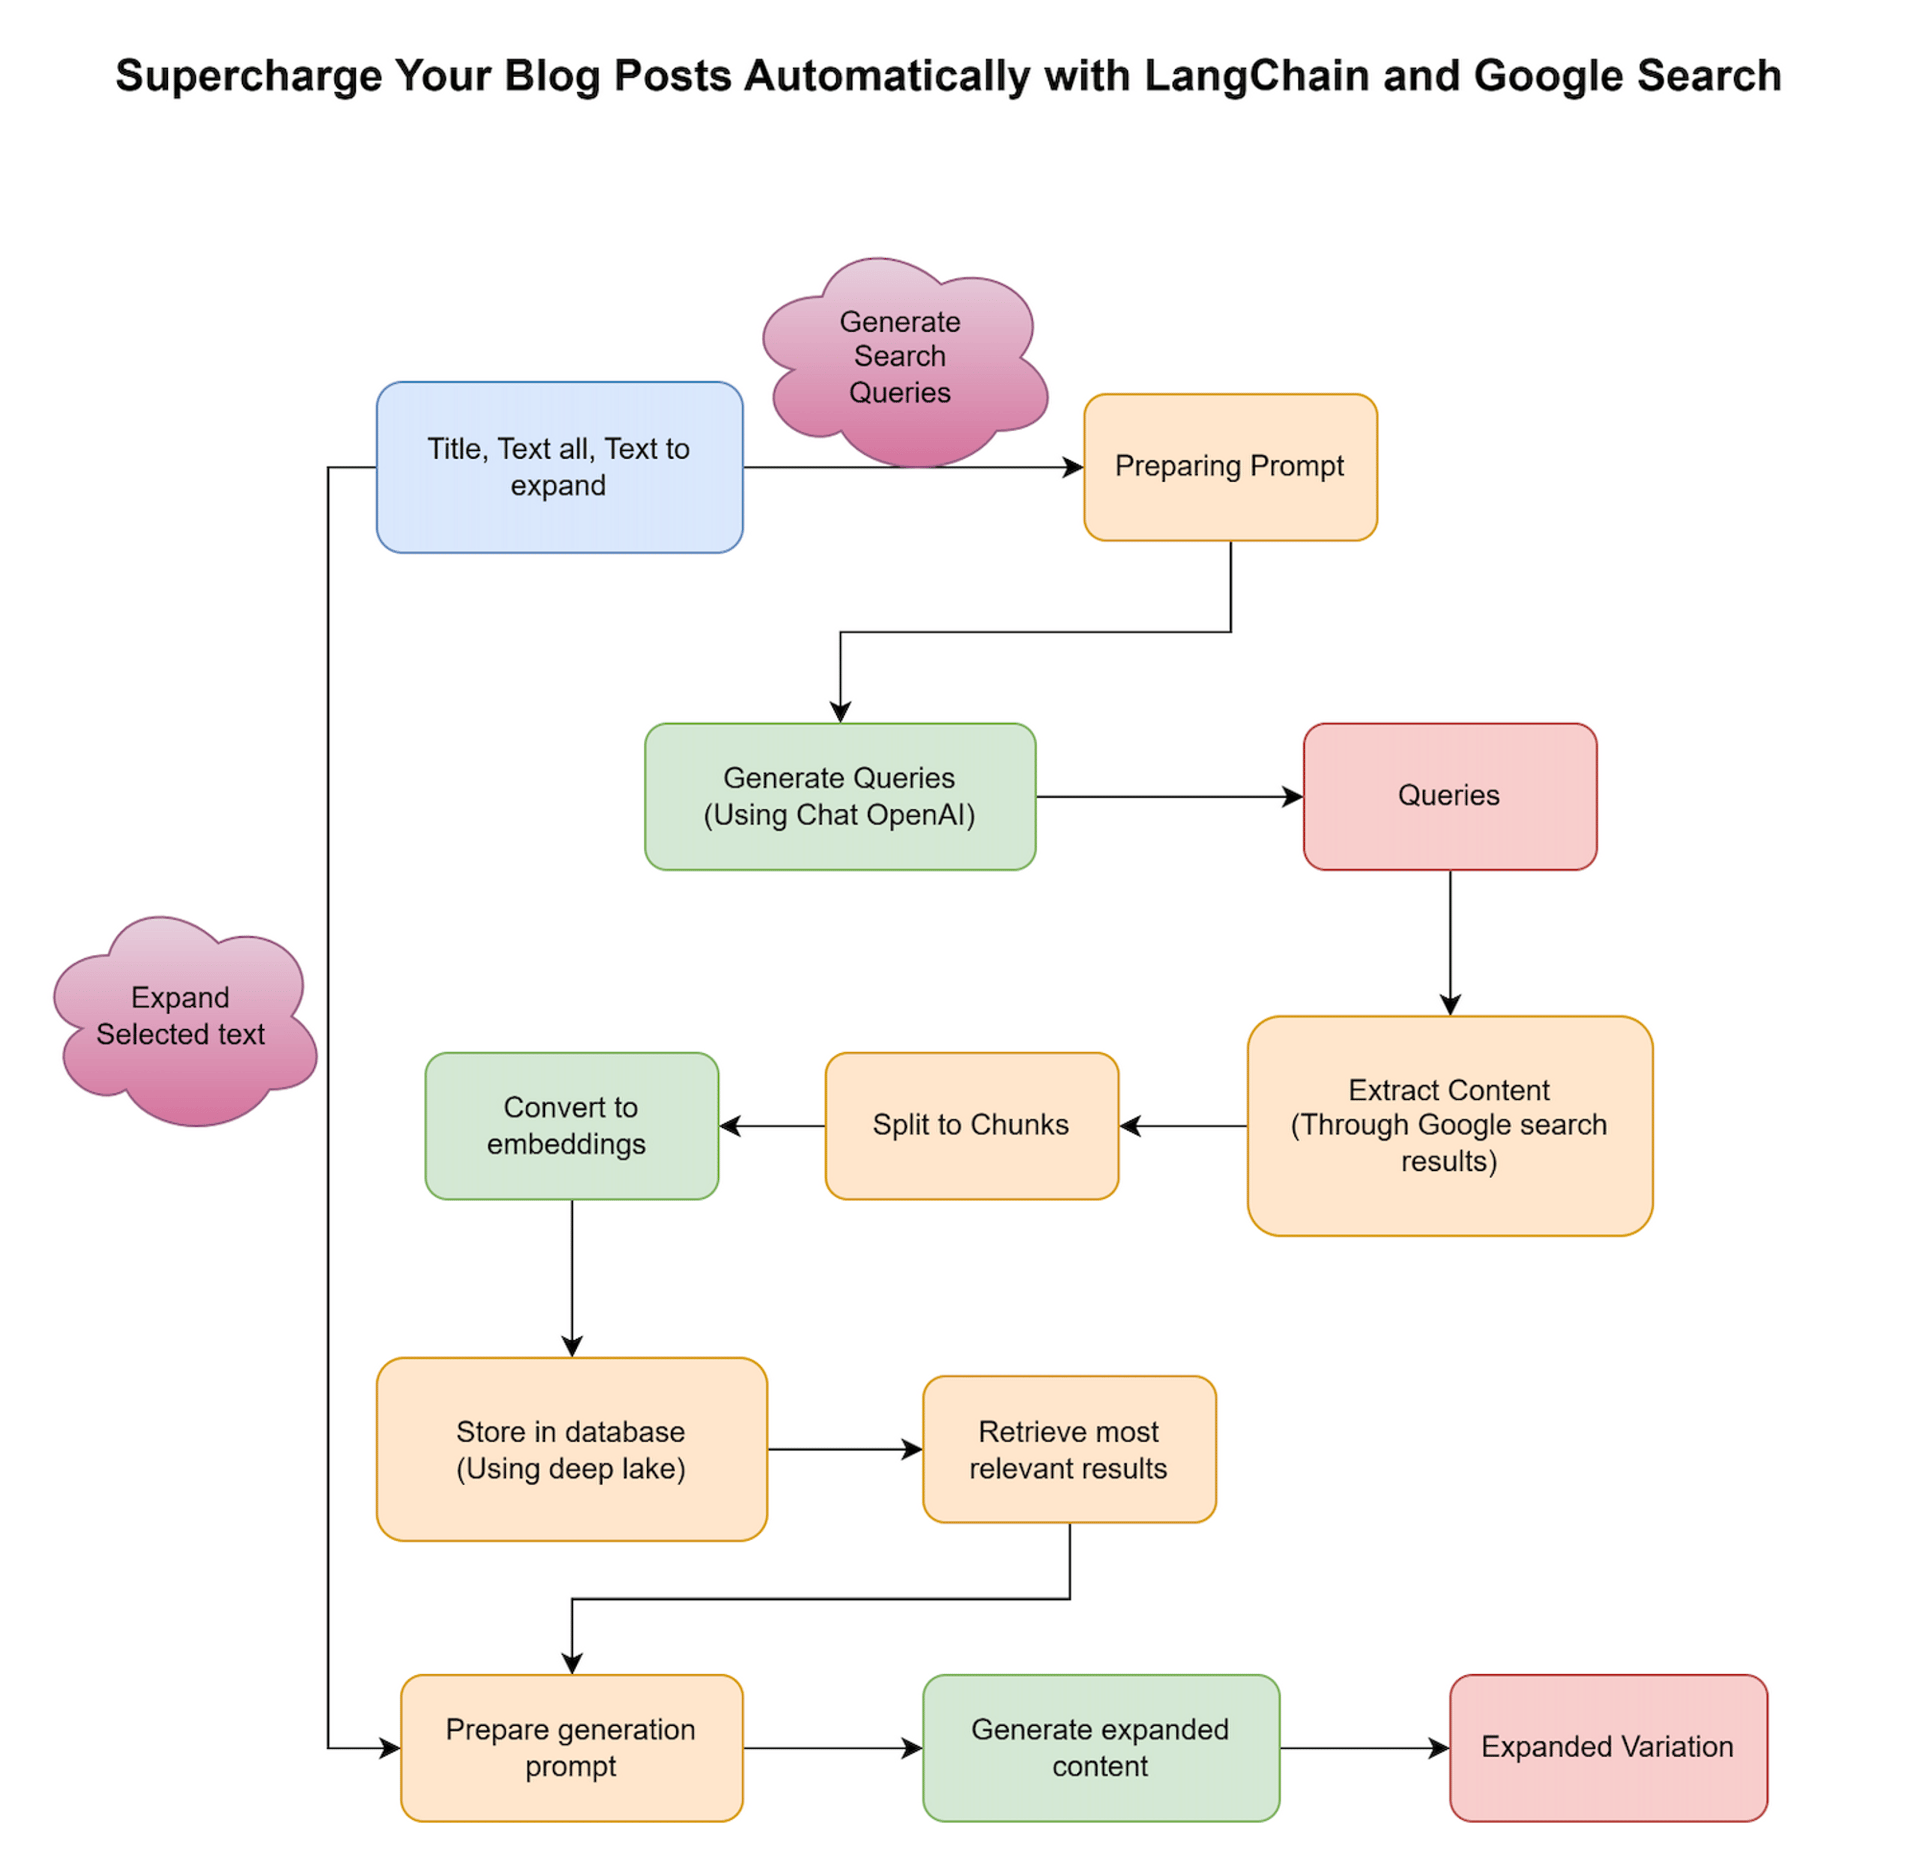

In [8]:
from PIL import Image
from io import BytesIO
from IPython.display import display
import requests

img_url = 'https://images.spr.so/cdn-cgi/imagedelivery/j42No7y-dcokJuNgXeA0ig/765d6cfa-6a75-4f58-bb7b-f4e47c0908ea/Screenshot_2023-06-09_at_13.42.59/w=1920,quality=80'
res = requests.get(img_url, stream=True)
img = Image.open(BytesIO(res.content))
display(img)

In [15]:
from langchain.chat_models.openai import ChatOpenAI
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from langchain.prompts.chat import (
    ChatPromptTemplate,
    HumanMessagePromptTemplate,
)

template = """ You are an exceptional copywriter and content creator.

You're reading an article with the following title:
----------------
{title}
----------------

You've just read the following piece of text from that article.
----------------
{text_all}
----------------

Inside that text, there's the following TEXT TO CONSIDER that you want to enrich with new details.
----------------
{text_to_change}
----------------

What are some simple and high-level Google queries that you'd do to search for more info to add to that paragraph?
Write 3 queries as a bullet point list, prepending each line with -.
"""

human_message_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template=template,
        input_variables=["text_to_change", "text_all", "title"],
    )
)
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])

# Before executing the following code, make sure to have
# your OpenAI key saved in the “OPENAI_API_KEY” environment variable.
chat = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.9)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)

response = chain.run({
    "text_to_change": text_to_change,
    "text_all": text_all,
    "title": title
})

queries = [line[2:] for line in response.split("\n")]
print(queries)

['"AI implications for elections"', '"AI implications for jobs"', '"AI implications for security"']


In [16]:
from langchain.tools import Tool
from langchain.utilities import GoogleSearchAPIWrapper

# Remember to set the "GOOGLE_CSE_ID" and "GOOGLE_API_KEY" environment variable.
search = GoogleSearchAPIWrapper()
TOP_N_RESULTS = 5

def top_n_results(query):
    return search.results(query, TOP_N_RESULTS)

tool = Tool(
    name = "Google Search",
    description="Search Google for recent results.",
    func=top_n_results
)

all_results = []

for query in queries:
    results = tool.run(query)
    all_results += results

In [17]:
all_results

[{'Result': 'No good Google Search Result was found'},
 {'title': 'Elon Musk and Steve Jobs Engage in an AI Discussion | Merca2.0',
  'link': 'https://www.merca20.com/elon-musk-and-steve-jobs-ai-discussion/',
  'snippet': "May 10, 2023 ... Nonetheless, Musk's genuine concerns regarding AI's implications for jobs and humanity remain a significant topic of discussion."},
 {'title': 'The High Beam Podcast',
  'link': 'https://www.spreaker.com/show/5916328/episodes/feed',
  'snippet': "In this thought-provoking episode, Dan discusses generative AI implications for jobs, industries, and individual privacy. You'll hear balanced perspectives\xa0..."},
 {'title': 'ChatGPT hype sparks hopes and fears around AI | Financial Times',
  'link': 'https://www.ft.com/content/ecda8734-4e3e-4e7e-9c26-ed5cbfde71e5',
  'snippet': "Feb 20, 2023 ... ... although only released in November has turbocharged the debate about AI's implications for jobs as well as a host of ethical issues."},
 {'title': 'Episode 6

In [18]:
import newspaper

pages_content = []

for result in all_results:
	try:
		article = newspaper.Article(result["link"])
		article.download()
		article.parse()

		if len(article.text) > 0:
			pages_content.append({ "url": result["link"], "text": article.text })
	except:
		continue

print("Number of pages: ", len(pages_content))

Number of pages:  3


In [19]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.docstore.document import Document

text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=100)

docs = []
for d in pages_content:
    chunks = text_splitter.split_text(d["text"])
    for chunk in chunks:
        new_doc = Document(page_content=chunk, metadata={ "source": d["url"] })
        docs.append(new_doc)

print("Number of chunks: ", len(docs))

Number of chunks:  4


In [20]:
from langchain.embeddings import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")

docs_embeddings = embeddings.embed_documents([doc.page_content for doc in docs])
query_embedding = embeddings.embed_query(text_to_change)

In [21]:
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

def get_top_k_indices(list_of_doc_vectors, query_vector, top_k):
    # convert the lists of vectors to numpy arrays
    list_of_doc_vectors = np.array(list_of_doc_vectors)
    query_vector = np.array(query_vector)

    # compute cosine similarities
    similarities = cosine_similarity(query_vector.reshape(1, -1), list_of_doc_vectors).flatten()

    # sort the vectors based on cosine similarity
    sorted_indices = np.argsort(similarities)[::-1]

    # retrieve the top K indices from the sorted list
    top_k_indices = sorted_indices[:top_k]

    return top_k_indices

top_k = 3
best_indexes = get_top_k_indices(docs_embeddings, query_embedding, top_k)
best_k_documents = [doc for i, doc in enumerate(docs) if i in best_indexes]

In [22]:
template = """You are an exceptional copywriter and content creator.

You're reading an article with the following title:
----------------
{title}
----------------

You've just read the following piece of text from that article.
----------------
{text_all}
----------------

Inside that text, there's the following TEXT TO CONSIDER that you want to enrich with new details.
----------------
{text_to_change}
----------------

Searching around the web, you've found this ADDITIONAL INFORMATION from distinct articles.
----------------
{doc_1}
----------------
{doc_2}
----------------
{doc_3}
----------------

Modify the previous TEXT TO CONSIDER by enriching it with information from the previous ADDITIONAL INFORMATION.
"""

human_message_prompt = HumanMessagePromptTemplate(
    prompt=PromptTemplate(
        template=template,
        input_variables=["text_to_change", "text_all", "title", "doc_1", "doc_2", "doc_3"],
    )
)
chat_prompt_template = ChatPromptTemplate.from_messages([human_message_prompt])

chat = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.9)
chain = LLMChain(llm=chat, prompt=chat_prompt_template)

response = chain.run({
    "text_to_change": text_to_change,
    "text_all": text_all,
    "title": title,
    "doc_1": best_k_documents[0].page_content,
    "doc_2": best_k_documents[1].page_content,
    "doc_3": best_k_documents[2].page_content
})

print("Text to Change: ", text_to_change)
print("Expanded Variation:", response)

Text to Change:   Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology.
Expanded Variation: Senators Josh Hawley and Richard Blumenthal expressed their recognition of the transformative nature of AI and the need to understand its implications for elections, jobs, and security. Blumenthal played an audio introduction using an AI voice cloning software trained on his speeches, demonstrating the potential of the technology. Elon Musk, the renowned entrepreneur and CEO of Tesla and SpaceX, has also voiced concerns about the impact of AI on jobs. He envisions a future where AI automation could result in a significant displacement of human workers, leaving a scarcity of meaningful tasks for humans to engage in. Musk's